In [20]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [21]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [40]:
data_dir = 'spectrogram_data_actual'

# TODO: Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + r'\train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + r'\valid', transform=test_transforms)
testdata=datasets.ImageFolder(data_dir + r'\test', transform=test_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16)
test_loader=torch.utils.data.DataLoader(testdata, batch_size=16,shuffle=True)

In [38]:
images,labels=next(iter(trainloader))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


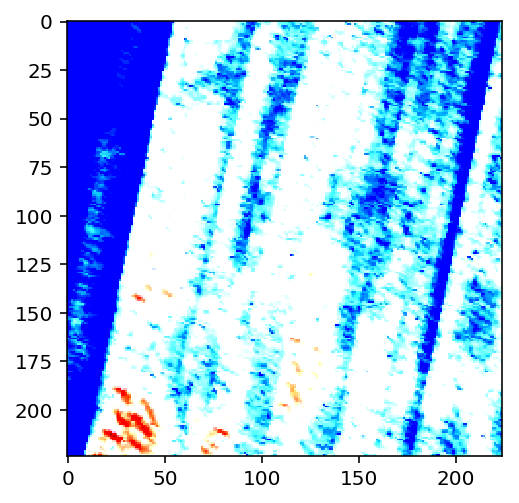

In [39]:
image=images[0].numpy()
label=labels[0]
plt.imshow(np.transpose(image, (1, 2, 0)))

In [6]:
model =models.densenet121(pretrained=True)
model


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [7]:
for param in model.parameters():
    param.requires_grad = False

model.classifier = nn.Sequential(nn.Linear(1024,512),nn.LeakyReLU(),nn.Linear(512,8))
criterion = nn.CrossEntropyLoss()


In [8]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [9]:
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)

In [10]:
import numpy as np
import time
def train(n_epochs,trainloader,testloader, resnet, optimizer, criterion):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    running_loss=0
    
  
    for epoch in range(n_epochs):
        
        
        for inputs, labels in trainloader:
            
        # Move input and label tensors to the default device
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            start = time.time()
            logps = resnet(inputs)
            loss = criterion(logps, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.item()
        
        
        resnet.eval()
        valid_loss=0
        accuracy=0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                logps = resnet(inputs)
                batch_loss = criterion(logps, labels)
                valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                
                top_p, top_class = logps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
           
        
            if valid_loss <= valid_loss_min:
                print("Validation loss decreased  Saving model")
                torch.save(resnet.state_dict(),'SER_densenet121.pt')
                valid_loss_min=valid_loss
                
            
            print(f"Device = cuda; Time per batch: {(time.time() - start):.3f} seconds")       
            print(f"Epoch /{epoch}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Test loss: {valid_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            resnet.train()

In [11]:
for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [12]:
model.load_state_dict(torch.load('SER_densenet121.pt'))

<All keys matched successfully>

In [13]:
train(60,trainloader,testloader, model, optimizer, criterion)

Validation loss decreased  Saving model
Device = cuda; Time per batch: 3.945 seconds
Epoch /0.. Train loss: 1.477.. Test loss: 1.355.. Test accuracy: 0.520
Validation loss decreased  Saving model
Device = cuda; Time per batch: 4.092 seconds
Epoch /1.. Train loss: 1.431.. Test loss: 1.245.. Test accuracy: 0.574
Device = cuda; Time per batch: 3.763 seconds
Epoch /2.. Train loss: 1.408.. Test loss: 1.253.. Test accuracy: 0.551
Device = cuda; Time per batch: 3.969 seconds
Epoch /3.. Train loss: 1.383.. Test loss: 1.250.. Test accuracy: 0.473
Validation loss decreased  Saving model
Device = cuda; Time per batch: 4.179 seconds
Epoch /4.. Train loss: 1.360.. Test loss: 1.180.. Test accuracy: 0.559
Validation loss decreased  Saving model
Device = cuda; Time per batch: 4.220 seconds
Epoch /5.. Train loss: 1.331.. Test loss: 1.107.. Test accuracy: 0.605
Device = cuda; Time per batch: 4.073 seconds
Epoch /6.. Train loss: 1.284.. Test loss: 1.154.. Test accuracy: 0.605
Device = cuda; Time per batc

Device = cuda; Time per batch: 4.487 seconds
Epoch /59.. Train loss: 0.573.. Test loss: 0.180.. Test accuracy: 0.949


In [14]:
model.load_state_dict(torch.load('SER_densenet121.pt'))

<All keys matched successfully>

In [15]:

valid_loss=0
accuracy=0
with torch.no_grad():
    model.eval()
    for images,labels in test_loader:
        images,lables=images.cuda(),labels.cuda()
        logps = model(images)
        batch_loss = criterion(logps, labels)
        valid_loss += batch_loss.item()
        top_p, top_class = logps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
print("LOSS-"+str(valid_loss/len(test_loader)))
      
print("ACCURACY-"+str(accuracy*100/len(test_loader)))

LOSS-0.13649250753223896
ACCURACY-96.75542116165161


In [16]:
emotions=testdata.classes
classes=testdata.classes
emotions

['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [23]:
# track test loss
test_loss = 0.0
batch_size=16
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))


with torch.no_grad():
    model.eval()
    # iterate over test data
    for batch_idx, (data, target) in enumerate(test_loader):
        # move tensors to GPU if CUDA is available
        data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item()*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy()) # if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
        # calculate test accuracy for each object class
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(test_loader.dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(8):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.139551

Test Accuracy of angry: 100% (36/36)
Test Accuracy of  calm: 89% (33/37)
Test Accuracy of disgust: 100% (19/19)
Test Accuracy of fearful: 100% (37/37)
Test Accuracy of happy: 97% (36/37)
Test Accuracy of neutral: 88% (16/18)
Test Accuracy of   sad: 97% (36/37)
Test Accuracy of surprised: 100% (19/19)

Test Accuracy (Overall): 96% (232/240)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actual Emotion-sad
Predicted Emotion-sad


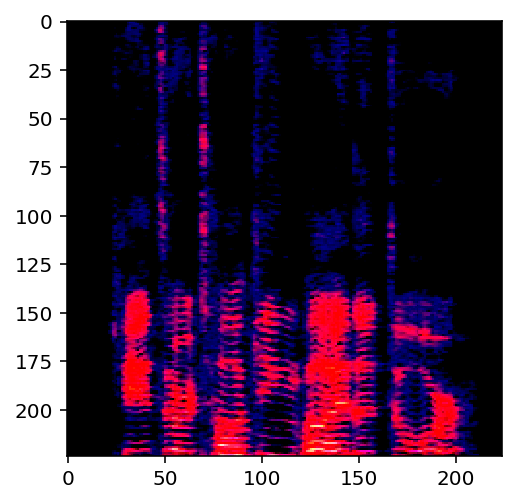

In [47]:
images,labels=next(iter(test_loader))
image=images[8]
label=labels[8]
image_vis=images[0].numpy()
plt.imshow(np.transpose(image_vis, (1, 2, 0)))
image,label=image.cuda(),label.cuda()
image.unsqueeze_(0)
predicted_label=np.argmax(model(image).detach().cpu())
print("Actual Emotion-"+str(emotions[label.detach().cpu().numpy()]))
print("Predicted Emotion-"+str(emotions[predicted_label.numpy()]))